Set up torchvision:
conda install torchvision -c soumith

In [1]:
# Imports necessary libraries and modules
from itertools import islice
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
import pickle
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from random import shuffle
from IPython.display import Image

# avoid error
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
# Directory path
os.chdir("C:\\Users\\lidao\\Desktop\\project3\\")
cwd = 'input'

# Hyper Parameters
num_epochs = 3
batch_size = 2
learning_rate = 0.00015
beta = 2

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
MODELS_PATH = 'output/models'
# TRAIN_PATH = cwd+'/train/'
# VALID_PATH = cwd+'/valid/'
VALID_PATH = cwd+'/sample/valid'
TRAIN_PATH = cwd+'/sample/train'
TEST_PATH = cwd+'/test'

if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [3]:
def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.mse_loss(C_prime, C)
    loss_secret = torch.nn.functional.mse_loss(S_prime, S)
    loss_all = loss_cover + B * loss_secret
    return loss_all, loss_cover, loss_secret

def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal_(torch.Tensor(tensor.size()), 0, 0.1)
    return Variable(tensor + noise)

In [4]:
# Preparation Network (2 conv layers)
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

# Join three networks in one module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_2, x_3

In [5]:
# Creates net object
net = Net()

In [6]:
# Creates training set
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

# Creates test set
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

In [7]:
def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.1)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            train_losses.append(train_loss.item())
            loss_history.append(train_loss.item())
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.item(), train_loss_cover.item(), train_loss_secret.item()))
    
        torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [8]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)

Training: Batch 1/90. Loss of 4.6703, cover loss of 1.1609, secret loss of 1.7547
Training: Batch 2/90. Loss of 1.4497, cover loss of 0.9340, secret loss of 0.2578
Training: Batch 3/90. Loss of 4.4631, cover loss of 1.7330, secret loss of 1.3650
Training: Batch 4/90. Loss of 4.2963, cover loss of 1.6855, secret loss of 1.3054
Training: Batch 5/90. Loss of 6.2602, cover loss of 2.1648, secret loss of 2.0477
Training: Batch 6/90. Loss of 5.3908, cover loss of 1.5656, secret loss of 1.9126
Training: Batch 7/90. Loss of 3.3671, cover loss of 1.1498, secret loss of 1.1086
Training: Batch 8/90. Loss of 2.5261, cover loss of 1.4577, secret loss of 0.5342
Training: Batch 9/90. Loss of 6.4170, cover loss of 2.9382, secret loss of 1.7394
Training: Batch 10/90. Loss of 4.8632, cover loss of 1.4720, secret loss of 1.6956
Training: Batch 11/90. Loss of 3.9924, cover loss of 0.9604, secret loss of 1.5160
Training: Batch 12/90. Loss of 3.1475, cover loss of 1.6166, secret loss of 0.7655
Training: Bat

Training: Batch 10/90. Loss of 1.7582, cover loss of 0.2022, secret loss of 0.7780
Training: Batch 11/90. Loss of 4.4501, cover loss of 0.4038, secret loss of 2.0231
Training: Batch 12/90. Loss of 3.3667, cover loss of 0.2773, secret loss of 1.5447
Training: Batch 13/90. Loss of 4.7631, cover loss of 0.1506, secret loss of 2.3063
Training: Batch 14/90. Loss of 2.3646, cover loss of 0.4549, secret loss of 0.9549
Training: Batch 15/90. Loss of 1.6536, cover loss of 0.1035, secret loss of 0.7751
Training: Batch 16/90. Loss of 2.0282, cover loss of 0.0985, secret loss of 0.9649
Training: Batch 17/90. Loss of 2.0683, cover loss of 0.5358, secret loss of 0.7663
Training: Batch 18/90. Loss of 2.5145, cover loss of 0.0789, secret loss of 1.2178
Training: Batch 19/90. Loss of 2.3581, cover loss of 0.3551, secret loss of 1.0015
Training: Batch 20/90. Loss of 1.9927, cover loss of 0.1096, secret loss of 0.9415
Training: Batch 21/90. Loss of 5.5543, cover loss of 0.1937, secret loss of 2.6803
Trai

Training: Batch 19/90. Loss of 6.8860, cover loss of 0.1965, secret loss of 3.3447
Training: Batch 20/90. Loss of 1.5323, cover loss of 0.3102, secret loss of 0.6110
Training: Batch 21/90. Loss of 4.4063, cover loss of 0.0895, secret loss of 2.1584
Training: Batch 22/90. Loss of 3.4882, cover loss of 0.4324, secret loss of 1.5279
Training: Batch 23/90. Loss of 3.0148, cover loss of 0.6182, secret loss of 1.1983
Training: Batch 24/90. Loss of 2.3187, cover loss of 0.4135, secret loss of 0.9526
Training: Batch 25/90. Loss of 4.2353, cover loss of 0.4438, secret loss of 1.8957
Training: Batch 26/90. Loss of 3.3948, cover loss of 0.6796, secret loss of 1.3576
Training: Batch 27/90. Loss of 3.2251, cover loss of 0.2116, secret loss of 1.5067
Training: Batch 28/90. Loss of 1.6090, cover loss of 0.3159, secret loss of 0.6466
Training: Batch 29/90. Loss of 2.5998, cover loss of 0.2426, secret loss of 1.1786
Training: Batch 30/90. Loss of 3.1973, cover loss of 0.1369, secret loss of 1.5302
Trai

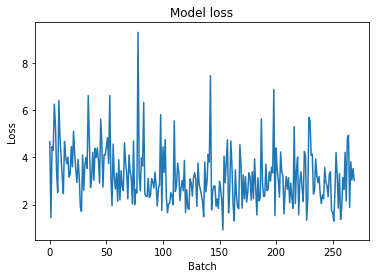

In [9]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

Total loss: 2.17 
Loss on secret: 0.88 
Loss on cover: 0.41


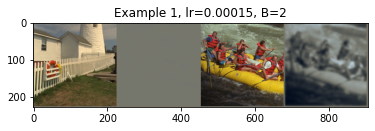

Total loss: 2.05 
Loss on secret: 0.93 
Loss on cover: 0.18


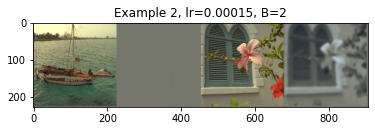

Total loss: 2.30 
Loss on secret: 0.76 
Loss on cover: 0.79


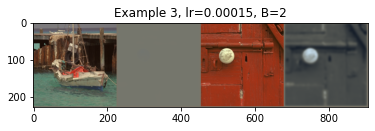

Total loss: 2.34 
Loss on secret: 1.08 
Loss on cover: 0.17


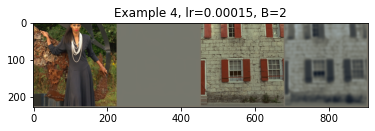

Average loss on test set: 1.95


In [41]:
# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    with torch.no_grad():
        test_secret = Variable(test_secret)
        test_cover = Variable(test_cover)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
    
    if idx in [0,1,2,3]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.item(), loss_secret.item(), loss_cover.item()))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(test_loss.item())
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))